Import model data for comparison with observations

In [1]:
import netCDF4 as nc
import datetime as dt
import pandas as pd
from pandas import Series, DataFrame
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import glob
import dateutil as dutil
from salishsea_tools import viz_tools, places
import xarray as xr
from salishsea_tools import evaltools as et
from collections import OrderedDict

%matplotlib inline

In [2]:

start_date = dt.datetime(2023,1,1)
end_date = dt.datetime(2023,12,31)
flen=1 # number of days per model output file. always 1 for 201905 and 201812 model runs
namfmt='nowcast' # for 201905 and 201812 model runs, this should always be 'nowcast'
# filemap is dictionary of the form variableName: fileType, where variableName is the name
# of the variable you want to extract and fileType designates the type of 
# model output file it can be found in (usually ptrc_T for biology, grid_T for temperature and 
# salinity)
filemap={'GRMESZDIAT':'graz_T','GRMESZPHY':'graz_T','GRMESZMICZ':'graz_T','GRMESZPON':'graz_T'}
# fdict is a dictionary mappy file type to its time resolution. Here, 1 means hourly output
# (1h file) and 24 means daily output (1d file). In certain runs, multiple time resolutions 
# are available
fdict={'graz_T':24,'grid_T':24} #24 for hours averaged 

In [3]:
PATH= '/results2/SalishSea/nowcast-green.202111/'

In [4]:
df2=pd.read_csv('/ocean/ksuchy/MOAD/analysis-karyn/notebooks/Evaluations/2023_SoG_ZoopProd_DepthSpecific.csv')

In [5]:
df2

,Cruise,Date,Station,STN_TIME,Z_lower,Z_upper,Lat,Lon,BPR (mgC m-3 day-1),daily P:B
0,2023-003,03/15/2023,Stn 42,12:00,5,5,49.028717,-123.103330,0.849489,0.067893
1,2023-003,03/15/2023,Stn 42,12:00,10,10,49.028717,-123.103330,3.473540,0.177075
2,2023-003,03/15/2023,Stn 42,12:00,20,20,49.028717,-123.103330,8.605914,0.474847
3,2023-003,03/15/2023,Stn 42,12:00,50,50,49.028717,-123.103330,9.166827,0.382759
4,2023-003,03/15/2023,Stn 42,12:00,150,150,49.028717,-123.103330,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
168,2023-066,05/13/2023,Stn 12,12:00,20,20,49.726133,-124.680567,0.000000,0.000000
169,2023-066,05/13/2023,Stn 12,12:00,50,50,49.726133,-124.680567,0.013851,0.001283
170,2023-066,05/13/2023,Stn 12,12:00,150,150,49.726133,-124.680567,0.007828,0.001177
171,2023-066,05/13/2023,Stn 12,12:00,250,250,49.726133,-124.680567,0.000000,0.000000


In [6]:
df2.rename(columns={'Date':'dtUTC'}, inplace=True)

### Convert date to proper format

In [7]:
df2['dtUTC'][0],df2['STN_TIME'][0]

('03/15/2023', '12:00')

In [8]:
df2['dtUTC'][0:10]

0    03/15/2023
1    03/15/2023
2    03/15/2023
3    03/15/2023
4    03/15/2023
5    03/15/2023
6    03/16/2023
7    03/16/2023
8    03/16/2023
9    03/16/2023
Name: dtUTC, dtype: object

In [9]:
df2['dtUTC'][0].split('/')

['03', '15', '2023']

In [10]:
dateslist=list()

In [11]:
for el in df2['dtUTC']:
    dateslist.append(el.split('/'))

In [12]:
timeslist=list()
for el in df2['STN_TIME']:
    timeslist.append(el.split(':'))

In [13]:
dts=list()
for ii,jj in zip(dateslist,timeslist):
    dts.append(dt.datetime(int(ii[2]),int(ii[0]),int(ii[1]),int(jj[0]),int(jj[1])))

In [14]:
df2['dtUTC']

0      03/15/2023
1      03/15/2023
2      03/15/2023
3      03/15/2023
4      03/15/2023
          ...    
168    05/13/2023
169    05/13/2023
170    05/13/2023
171    05/13/2023
172    05/13/2023
Name: dtUTC, Length: 173, dtype: object

In [15]:
df2['dtUTC'] = df2['dtUTC'].apply(lambda x:
    dt.datetime.strptime(x, '%m/%d/%Y'))

In [16]:
df2['dtUTC']

0     2023-03-15
1     2023-03-15
2     2023-03-15
3     2023-03-15
4     2023-03-15
         ...    
168   2023-05-13
169   2023-05-13
170   2023-05-13
171   2023-05-13
172   2023-05-13
Name: dtUTC, Length: 173, dtype: datetime64[ns]

In [17]:
data=et.matchData(df2,filemap,fdict,start_date,end_date,namfmt,PATH,flen,quiet=False,method='vertNet');

ftype=graz_T, are you sure? (if yes, add to list)


In [18]:
data

,Cruise,dtUTC,Station,STN_TIME,Z_lower,Z_upper,Lat,Lon,BPR (mgC m-3 day-1),daily P:B,j,i,mod_GRMESZDIAT,mod_GRMESZPHY,mod_GRMESZMICZ,mod_GRMESZPON,k_upper,k_lower
0,2023-003,2023-03-15,Stn 42,12:00,5,5,49.028717,-123.103330,0.849489,0.067893,399,312,NaN,NaN,NaN,NaN,-1,-1
1,2023-003,2023-03-15,Stn 42,12:00,10,10,49.028717,-123.103330,3.473540,0.177075,399,312,NaN,NaN,NaN,NaN,-1,-1
2,2023-003,2023-03-15,Stn 42,12:00,20,20,49.028717,-123.103330,8.605914,0.474847,399,312,NaN,NaN,NaN,NaN,-1,-1
3,2023-003,2023-03-15,Stn 42,12:00,50,50,49.028717,-123.103330,9.166827,0.382759,399,312,NaN,NaN,NaN,NaN,-1,-1
4,2023-003,2023-03-15,Stn 42,12:00,150,150,49.028717,-123.103330,0.000000,0.000000,399,312,NaN,NaN,NaN,NaN,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,2023-029,2023-10-12,Stn 12,12:00,250,250,49.726133,-124.680567,0.000000,0.000000,646,168,0.000000e+00,0.000000e+00,0.0,0.000000e+00,32,32
169,2023-029,2023-10-12,Stn 12,12:00,150,150,49.726133,-124.680567,0.000000,0.000000,646,168,0.000000e+00,0.000000e+00,0.0,0.000000e+00,28,28
170,2023-029,2023-10-12,Stn 12,12:00,50,50,49.726133,-124.680567,0.164719,0.006107,646,168,1.331532e-07,5.788735e-08,0.0,1.447629e-07,23,23
171,2023-029,2023-10-12,Stn 12,12:00,10,10,49.726133,-124.680567,0.000000,0.000000,646,168,1.084052e-06,2.239624e-07,0.0,5.093685e-07,9,9


In [19]:
data.keys()

Index(['Cruise', 'dtUTC', 'Station', 'STN_TIME', 'Z_lower', 'Z_upper', 'Lat',
       'Lon', 'BPR (mgC m-3 day-1)', 'daily P:B', 'j', 'i', 'mod_GRMESZDIAT',
       'mod_GRMESZPHY', 'mod_GRMESZMICZ', 'mod_GRMESZPON', 'k_upper',
       'k_lower'],
      dtype='object')

In [20]:
cm1=cmocean.cm.thermal
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [21]:
data.keys()

Index(['Cruise', 'dtUTC', 'Station', 'STN_TIME', 'Z_lower', 'Z_upper', 'Lat',
       'Lon', 'BPR (mgC m-3 day-1)', 'daily P:B', 'j', 'i', 'mod_GRMESZDIAT',
       'mod_GRMESZPHY', 'mod_GRMESZMICZ', 'mod_GRMESZPON', 'k_upper',
       'k_lower'],
      dtype='object')

In [22]:
data['mod_prod']=(data['mod_GRMESZDIAT']+data['mod_GRMESZPHY']+data['mod_GRMESZMICZ']+data['mod_GRMESZPON'])*86400*0.3*5.7*12

In [23]:
data

,Cruise,dtUTC,Station,STN_TIME,Z_lower,Z_upper,Lat,Lon,BPR (mgC m-3 day-1),daily P:B,j,i,mod_GRMESZDIAT,mod_GRMESZPHY,mod_GRMESZMICZ,mod_GRMESZPON,k_upper,k_lower,mod_prod
0,2023-003,2023-03-15,Stn 42,12:00,5,5,49.028717,-123.103330,0.849489,0.067893,399,312,NaN,NaN,NaN,NaN,-1,-1,NaN
1,2023-003,2023-03-15,Stn 42,12:00,10,10,49.028717,-123.103330,3.473540,0.177075,399,312,NaN,NaN,NaN,NaN,-1,-1,NaN
2,2023-003,2023-03-15,Stn 42,12:00,20,20,49.028717,-123.103330,8.605914,0.474847,399,312,NaN,NaN,NaN,NaN,-1,-1,NaN
3,2023-003,2023-03-15,Stn 42,12:00,50,50,49.028717,-123.103330,9.166827,0.382759,399,312,NaN,NaN,NaN,NaN,-1,-1,NaN
4,2023-003,2023-03-15,Stn 42,12:00,150,150,49.028717,-123.103330,0.000000,0.000000,399,312,NaN,NaN,NaN,NaN,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,2023-029,2023-10-12,Stn 12,12:00,250,250,49.726133,-124.680567,0.000000,0.000000,646,168,0.000000e+00,0.000000e+00,0.0,0.000000e+00,32,32,0.000000
169,2023-029,2023-10-12,Stn 12,12:00,150,150,49.726133,-124.680567,0.000000,0.000000,646,168,0.000000e+00,0.000000e+00,0.0,0.000000e+00,28,28,0.000000
170,2023-029,2023-10-12,Stn 12,12:00,50,50,49.726133,-124.680567,0.164719,0.006107,646,168,1.331532e-07,5.788735e-08,0.0,1.447629e-07,23,23,0.595355
171,2023-029,2023-10-12,Stn 12,12:00,10,10,49.726133,-124.680567,0.000000,0.000000,646,168,1.084052e-06,2.239624e-07,0.0,5.093685e-07,9,9,3.222089


In [24]:
data.keys()

Index(['Cruise', 'dtUTC', 'Station', 'STN_TIME', 'Z_lower', 'Z_upper', 'Lat',
       'Lon', 'BPR (mgC m-3 day-1)', 'daily P:B', 'j', 'i', 'mod_GRMESZDIAT',
       'mod_GRMESZPHY', 'mod_GRMESZMICZ', 'mod_GRMESZPON', 'k_upper',
       'k_lower', 'mod_prod'],
      dtype='object')

In [25]:
print(data['BPR (mgC m-3 day-1)'].min())
print(data['BPR (mgC m-3 day-1)'].max())


0.0
30.09486754


In [26]:
print(data['mod_prod'].min())
print(data['mod_prod'].max())

0.0
44.07050287569291


In [27]:
def byDepth(ax,obsvar,modvar,lims):
    SI=et.varvarPlot(ax,data,obsvar,modvar,'Z_lower',(15,25),'z','m',('orange','darkturquoise','navy'))
    l=ax.legend(handles=SI)
    ax.set_xlabel('Log10 Observations (mg C m$^{-3}$ d$^{-1}$)+0.001')
    ax.set_ylabel('Log10 Z2 Model (mg C m$^{-3}$ d$^{-1}$)+0.001')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return SI,l

(0.0, 40.0)

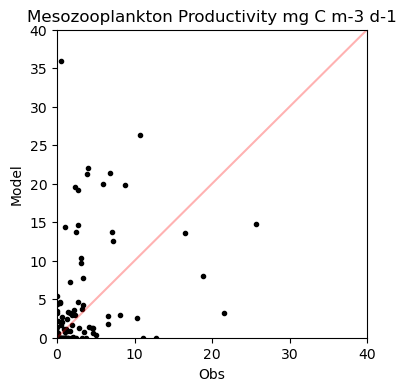

In [28]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
fig.subplots_adjust(hspace=1)
ax.plot(data['BPR (mgC m-3 day-1)'],data['mod_prod'],'k.')
ax.set_title('Mesozooplankton Productivity mg C m-3 d-1')
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.plot((0,40),(0,40),'r-',alpha=.3)
ax.set_xlim(0,40)
ax.set_ylim(0,40)

Text(0.5, 1.0, 'Mesozooplankton Productivity mg C m-3 d-1 By Depth')

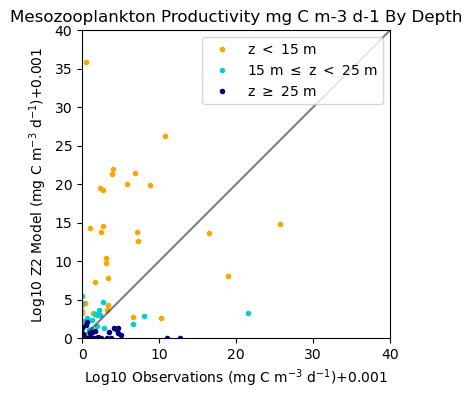

In [29]:
obsvar='BPR (mgC m-3 day-1)'
modvar='mod_prod'

fig, ax = plt.subplots(1,1,figsize = (4,4))
SI,l=byDepth(ax,obsvar,modvar,(0,40))
ax.set_title('Mesozooplankton Productivity mg C m-3 d-1 By Depth')

In [30]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
    return np.log10(x+.001)

In [31]:
data['L10Productivity']=logt(data['BPR (mgC m-3 day-1)'])
data['L10mod_prod']=logt(data['mod_prod'])

### Depth-specific Point by Point comparisions of model vs obs

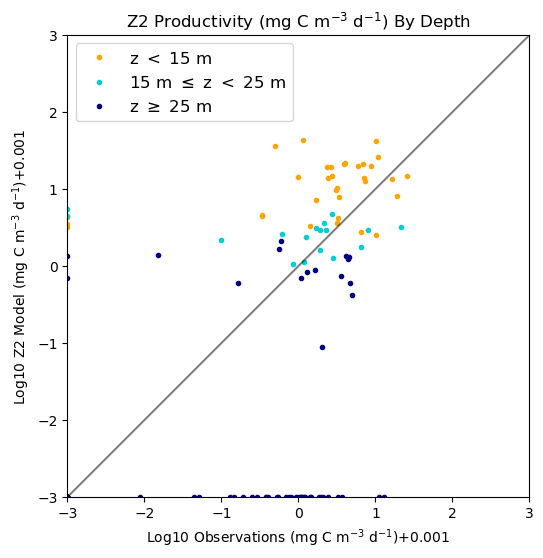

In [32]:
obsvar2='L10Productivity'
modvar2='L10mod_prod'

fig, ax = plt.subplots(1,1,figsize = (6,6))
SI,l=byDepth(ax,obsvar2,modvar2,(-3,3))
ax.set_title('Z2 Productivity (mg C m$^{-3}$ d$^{-1}$) By Depth',fontsize=12)
ax.legend(frameon=True,fontsize=12)
#fig.savefig('SaanichLog10ModelvsObsProductivity.jpg',bbox_inches='tight')

(-126.0, -121.0, 47.0, 51.0)

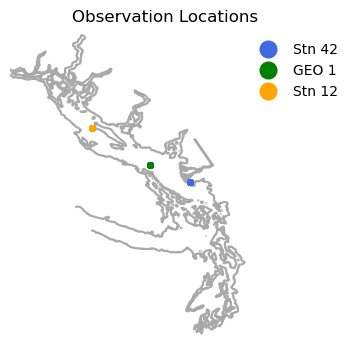

In [33]:
fig, ax = plt.subplots(1,1,figsize = (4,4))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1,color='darkgrey')
colors=('royalblue',
'green',
'orange',
'mediumspringgreen',
'black',
'darkviolet',
 'lightblue',
'fuchsia',
'firebrick','lime','darkgoldenrod','darkorange','deepskyblue','teal','darkgreen','darkblue','slateblue','purple')
datreg=dict()
for ind, iregion in enumerate(data.Station.unique()):
    datreg[iregion] = data.loc[data.Station==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'o',
            color = colors[ind], label=iregion,markersize=4)
ax.set_ylim(47, 51)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(bbox_to_anchor=(1.1, 1),frameon=False,markerscale=3.)
ax.set_xlim(-126, -121);
ax.set_title('Observation Locations');
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False,markerscale=3.,fontsize=11)
ax.axis("off")
#fig.savefig('SalishSeaObservationLocations_noframe.jpg',bbox_inches='tight')

In [34]:
data['Month'] = data['dtUTC'].dt.month

In [35]:
def byRegion(ax,obsvar,modvar,lims):
    SS=[]
    for ind, iregion in enumerate(data.Station.unique()):
        #ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                #color = colors[ind], label=iregion)
        SS0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                          cols=(colors[ind],),lname=iregion)
        SS.append(SS0)
    l=ax.legend(handles=[ip[0][0] for ip in SS])
    ax.set_xlabel('Log10 Observations (mg C m$^{-3}$ d$^{-1}$)+0.001')
    ax.set_ylabel('Log10 Model (mg C m$^{-3}$ d$^{-1}$)+0.001')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return SS,l

In [36]:
#data['Month']=[ii.month for ii in data['dtUTC']]
DJF=data.loc[(data.Month==12)|(data.Month==1)|(data.Month==2)]
MAM=data.loc[(data.Month==3)|(data.Month==4)|(data.Month==5)]
JJA=data.loc[(data.Month==6)|(data.Month==7)|(data.Month==8)]
SON=data.loc[(data.Month==9)|(data.Month==10)|(data.Month==11)]

In [37]:
def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    SS=et.varvarPlot(ax[0],DJF,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Winter')
    SS=et.varvarPlot(ax[1],MAM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Spring')
    SS=et.varvarPlot(ax[2],JJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('Summer')
    SS=et.varvarPlot(ax[3],SON,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Autumn')
    return 

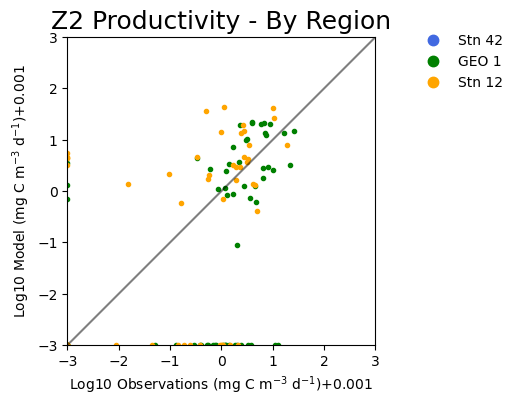

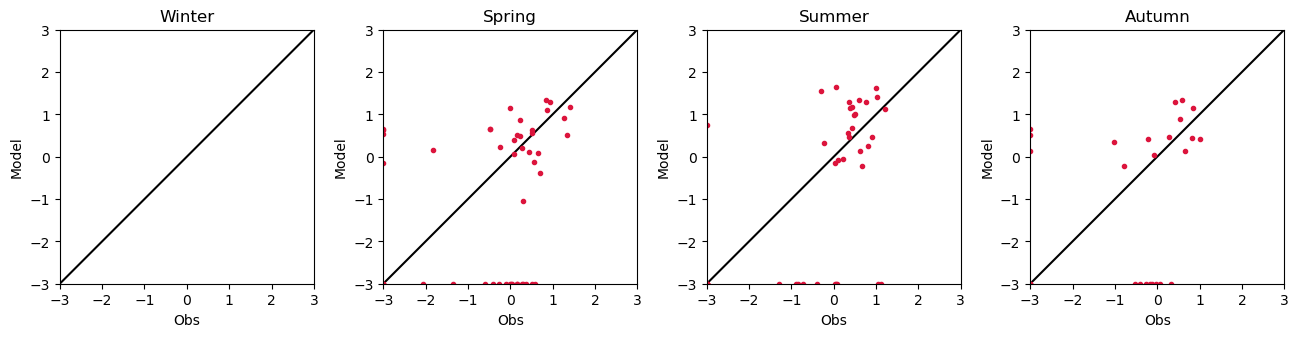

In [38]:
fig, ax = plt.subplots(1,1,figsize = (5,4))     
SS,l=byRegion(ax,'L10Productivity','L10mod_prod',(-3,3))
ax.set_title('Z2 Productivity - By Region',fontsize=18)
ax.legend(bbox_to_anchor=(1.1, 1.05),frameon=False,markerscale=2.5)
#fig.savefig('SalishSeaDIMicroZoopEval_byregion_noLegend.jpg',bbox_inches='tight')





fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Productivity','L10mod_prod',(-3,3))

In [39]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({
                      'All':data,
                      'Winter':DJF,
                      'Spring':MAM,
                      'Summer':JJA,
                      'Autumn': SON,})
for iregion in data.Station.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['All', 'Winter', 'Spring', 'Summer', 'Autumn', 'Stn 42', 'GEO 1', 'Stn 12'])

In [40]:
# Defining variables needed for mesozooplankton evaluations
obsvar4='L10Productivity'
modvar4='L10mod_prod'
year=2023 #how do I calculate for all years?



In [41]:
statsDict={year:dict()}
statsDict[year]['MicroZ']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['MicroZ'][isub]=dict()
    var=statsDict[year]['MicroZ'][isub]
    var['N'],var['mmean'],var['omean'],var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar4]],
                                                                     statsubs[isub].loc[:,[modvar4]])
tbl,tdf=et.displayStats(statsDict[year]['MicroZ'],level='Subset',suborder=list(statsubs.keys()))
tbl

#tbl.to_excel("SalishSeaMicrozoopEvalStats.xlsx")

All
Winter
Spring
Summer
Autumn
Stn 42
GEO 1
Stn 12
